<a href="https://colab.research.google.com/github/NeginS98/time-series-Forecasting-Climate-data/blob/main/Climate_TimeSeriesModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import libraries**

In [ ]:
import pandas as pd 
import numpy as np 
import os 
import random 
import seaborn as sns
import datetime
import warnings 
%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn import metrics

## **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/DailyDelhiClimateTest.csv" "Test.csv"
!cp "/content/drive/My Drive/Colab Notebooks/DailyDelhiClimateTrain.csv" "Train.csv"

In [ ]:
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv')

## **Visualization**

In [ ]:
infoTrain = pd.DataFrame({'Missing Train': Train.isnull().sum(), 
                     'Type of Train': Train.dtypes, 
                     'Count of Train': len(Train)})

infoTest = pd.DataFrame({'Missing Test': Test.isnull().sum(), 
                     'Type of Test': Test.dtypes, 
                     'Count of Test': len(Test)})

In [ ]:
Train.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [ ]:
Train['date'] = pd.to_datetime(Train['date'],format='%Y-%m-%d')
Train['year'] = pd.DatetimeIndex(Train['date']).year
Train['month'] = pd.DatetimeIndex(Train['date']).month
Train['day'] = pd.DatetimeIndex(Train['date']).day

In [ ]:
Test['date'] = pd.to_datetime(Test['date'],format='%Y-%m-%d')
Test['year'] = pd.DatetimeIndex(Test['date']).year
Test['month'] = pd.DatetimeIndex(Test['date']).month
Test['day'] = pd.DatetimeIndex(Test['date']).day

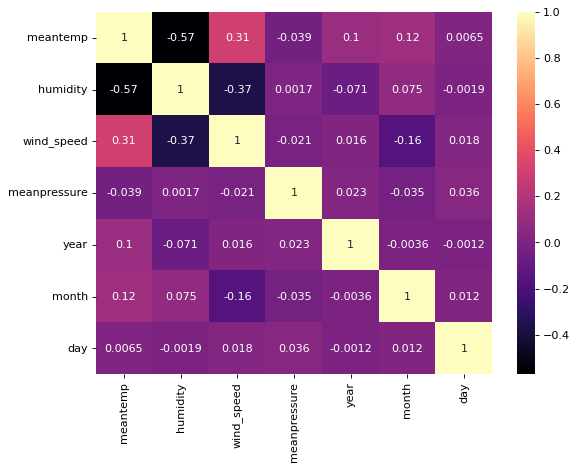

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(Train.corr(), annot=True, cmap='magma')
plt.show()

In [ ]:
Train.year.unique()

array([2013, 2014, 2015, 2016, 2017])

In [ ]:
Test.year.unique()

array([2017])

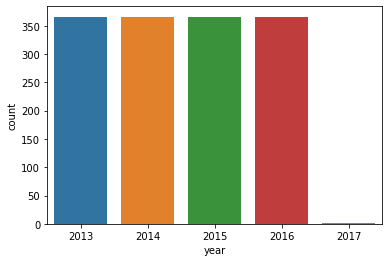

In [ ]:
sns.countplot(x="year", data=Train)
plt.show()

In [ ]:
Train.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'year',
       'month', 'day'],
      dtype='object')

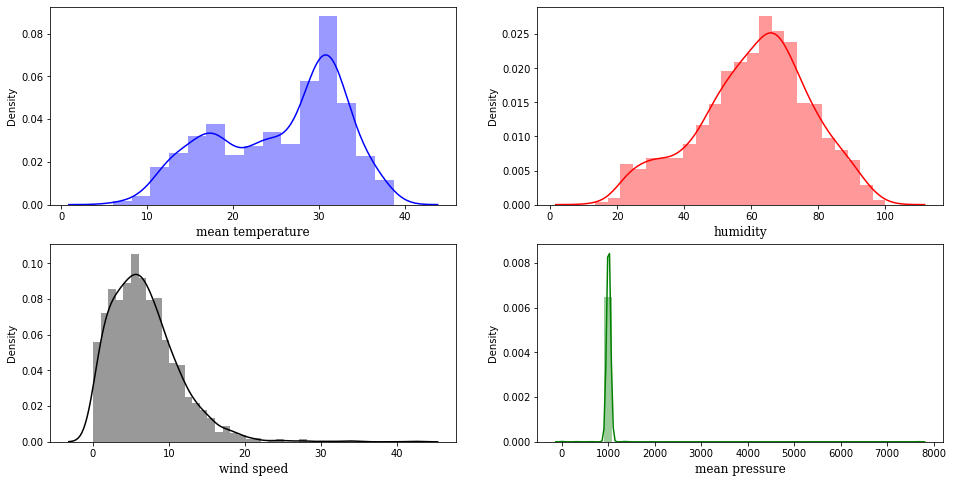

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
sns.distplot(Train.meantemp, color='b', ax=ax[0, 0])
ax[0, 0].set_xlabel('mean temperature', fontfamily='serif', fontsize=12)
sns.distplot(Train.humidity, color='r', ax=ax[0, 1])
ax[0, 1].set_xlabel('humidity', fontfamily='serif', fontsize=12)
sns.distplot(Train.wind_speed, color='k', ax=ax[1,0])
ax[1, 0].set_xlabel('wind speed', fontfamily='serif', fontsize=12)
sns.distplot(Train.meanpressure, color='g', ax=ax[1, 1])
ax[1, 1].set_xlabel('mean pressure', fontfamily='serif', fontsize=12)
sns.set_theme()
plt.show()

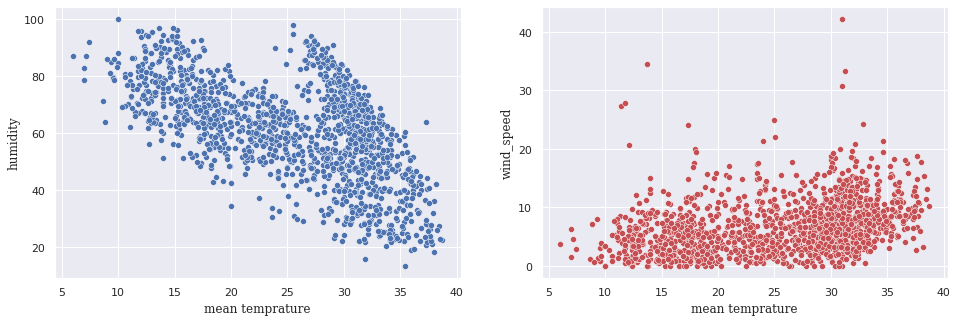

In [ ]:
f, ax = plt.subplots(ncols=2, figsize=(16, 5))
sns.set_theme()
sns.scatterplot(y=Train.humidity, x=Train.meantemp, ax=ax[0], color='b')
ax[0].set_ylabel(ylabel='humidity', fontsize=12, fontfamily='serif')
ax[0].set_xlabel(xlabel='mean temprature', fontsize=12, fontfamily='serif')

sns.scatterplot(y=Train.wind_speed, x=Train.meantemp, ax=ax[1], color='r')
ax[1].set_ylabel(ylabel='wind_speed', fontsize=12, fontfamily='serif')
ax[1].set_xlabel(xlabel='mean temprature', fontsize=12, fontfamily='serif')
plt.show()

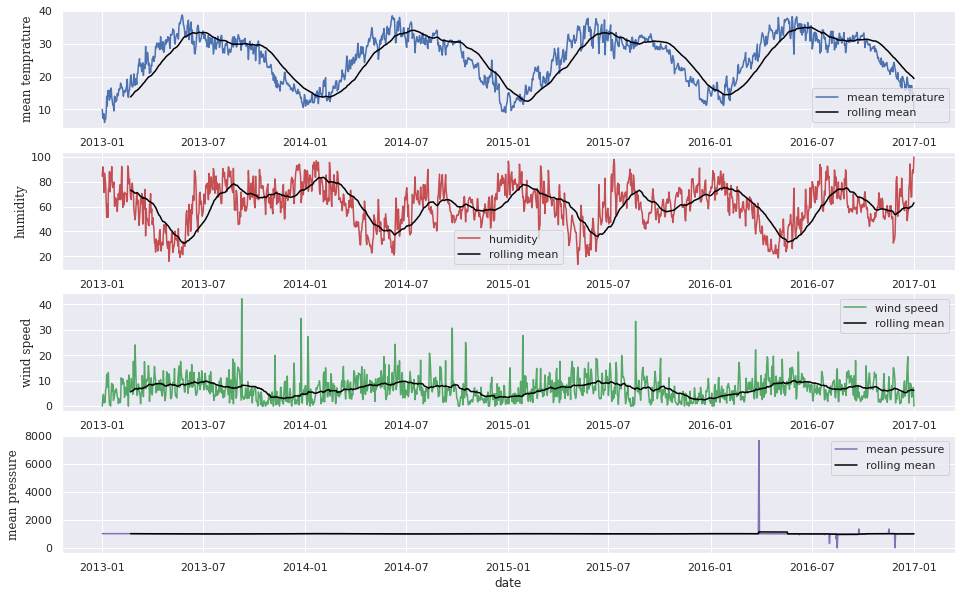

In [ ]:
rolling_window = 52
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 10))
sns.set_theme()
sns.lineplot(x=Train.date, y=Train.meantemp, ax=ax[0], color='b', label='mean temprature')
sns.lineplot(x=Train.date, y=Train.meantemp.rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
ax[0].set_ylabel(ylabel='mean temprature', fontsize=12, fontfamily='serif')

sns.lineplot(x=Train.date, y=Train.humidity, ax=ax[1], color='r', label='humidity')
sns.lineplot(x=Train.date, y=Train.humidity.rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
ax[1].set_ylabel(ylabel='humidity', fontsize=12, fontfamily='serif')

sns.lineplot(x=Train.date, y=Train.wind_speed, ax=ax[2], color='g', label='wind speed')
sns.lineplot(x=Train.date, y=Train.wind_speed.rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
ax[2].set_ylabel(ylabel='wind speed', fontsize=12, fontfamily='serif')

sns.lineplot(x=Train.date, y=Train.meanpressure, ax=ax[3], color='m', label='mean pessure')
sns.lineplot(x=Train.date, y=Train.meanpressure.rolling(rolling_window).mean(), ax=ax[3], color='black', label='rolling mean')
ax[3].set_ylabel(ylabel='mean pressure', fontsize=12, fontfamily='serif')
plt.show()

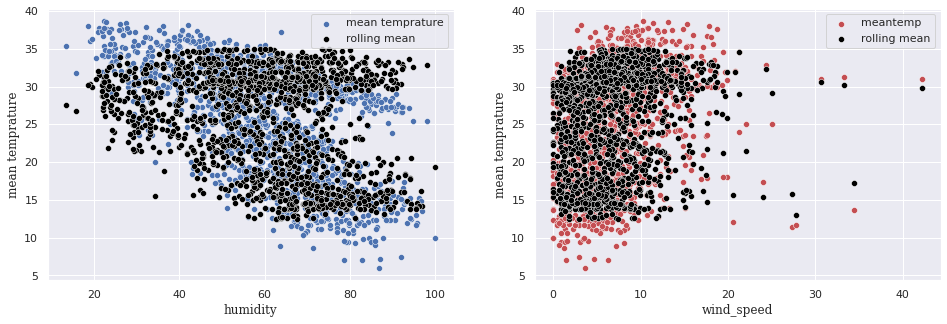

In [ ]:
rolling_window = 52
f, ax = plt.subplots(ncols=2, figsize=(16, 5))
sns.set_theme()
sns.scatterplot(x=Train.humidity, y=Train.meantemp, ax=ax[0], color='b', label='mean temprature')
sns.scatterplot(x=Train.humidity, y=Train.meantemp.rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
ax[0].set_xlabel(xlabel='humidity', fontsize=12, fontfamily='serif')
ax[0].set_ylabel(ylabel='mean temprature', fontsize=12, fontfamily='serif')

sns.scatterplot(x=Train.wind_speed, y=Train.meantemp, ax=ax[1], color='r', label='meantemp')
sns.scatterplot(x=Train.wind_speed, y=Train.meantemp.rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
ax[1].set_xlabel(xlabel='wind_speed', fontsize=12, fontfamily='serif')
ax[1].set_ylabel(ylabel='mean temprature', fontsize=12, fontfamily='serif')


plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = Train.copy()
decompose_cols =  ['meantemp','humidity', 'wind_speed', 'meanpressure']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], freq=52, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal

In [ ]:
df.drop(['year', 'month', 'day'], axis=1, inplace=True)
df

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_seasonal,humidity_trend,humidity_seasonal,wind_speed_trend,wind_speed_seasonal,meanpressure_trend,meanpressure_seasonal
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,9.120427,0.417341,83.186077,1.661187,4.397351,-0.411740,1021.199815,-3.802653
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,9.302375,0.356509,82.845341,1.254384,4.458765,-0.205492,1021.076499,-2.028871
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,9.484323,0.089876,82.504605,0.285679,4.520180,0.732435,1020.953183,-1.975451
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,9.666271,-0.228059,82.163870,1.552845,4.581594,-0.829635,1020.829867,-2.260457
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,9.848219,0.041643,81.823134,0.666221,4.643009,-0.039055,1020.706551,-2.737264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,15.352923,0.356509,61.279231,1.254384,5.732123,-0.205492,989.312482,-2.028871
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,15.172164,0.089876,61.362214,0.285679,5.723371,0.732435,988.949766,-1.975451
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,14.991406,-0.228059,61.445197,1.552845,5.714619,-0.829635,988.587050,-2.260457
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,14.810647,0.041643,61.528180,0.666221,5.705867,-0.039055,988.224334,-2.737264


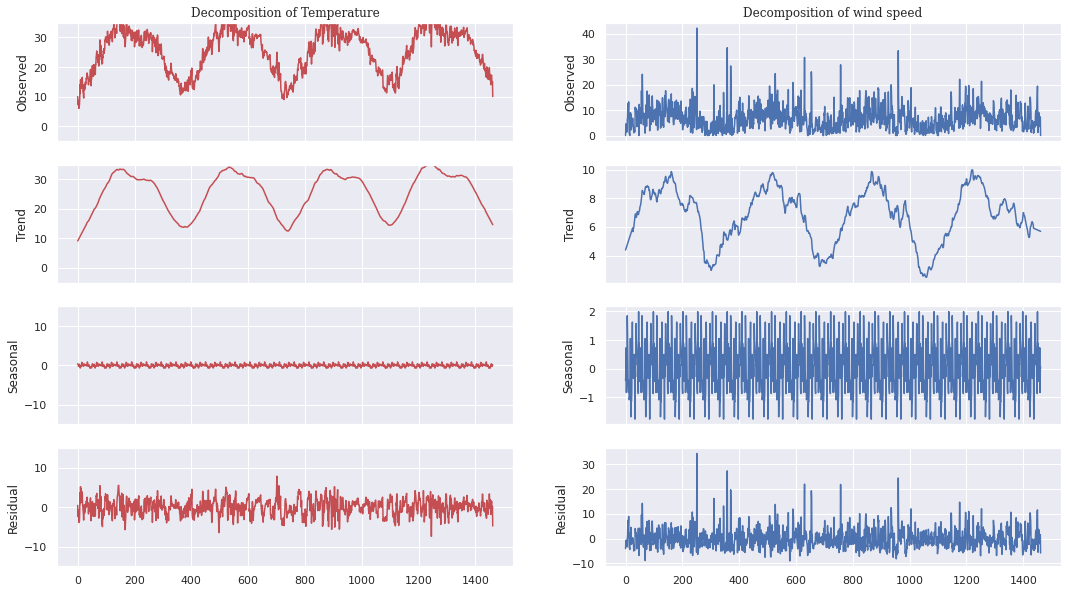

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(18,10))
res = seasonal_decompose(df.meantemp, freq=52, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=12, fontfamily='serif')
res.observed.plot(ax=ax[0,0], legend=False, color='r')
ax[0,0].set_ylabel('Observed', fontsize=12)
ax[0,0].set_ylim([-5, 35])
res.trend.plot(ax=ax[1,0], legend=False, color='r')
ax[1,0].set_ylabel('Trend', fontsize=12)
ax[1,0].set_ylim([-5, 35])
res.seasonal.plot(ax=ax[2,0], legend=False, color='r')
ax[2,0].set_ylabel('Seasonal', fontsize=12)
ax[2,0].set_ylim([-15, 15])
res.resid.plot(ax=ax[3,0], legend=False, color='r')
ax[3,0].set_ylabel('Residual', fontsize=12)
ax[3,0].set_ylim([-15, 15])

ax[0,1].set_title('Decomposition of wind speed', fontsize=12, fontfamily='serif')
res = seasonal_decompose(df.wind_speed, freq=52, model='additive', extrapolate_trend='freq')
res.observed.plot(ax=ax[0, 1], legend=False, color='b')
ax[0, 1].set_ylabel('Observed', fontsize=12)
res.trend.plot(ax=ax[1, 1], legend=False, color='b')
ax[1, 1].set_ylabel('Trend', fontsize=12)
res.seasonal.plot(ax=ax[2, 1], legend=False, color='b')
ax[2, 1].set_ylabel('Seasonal', fontsize=12)
res.resid.plot(ax=ax[3, 1], legend=False, color='b')
ax[3, 1].set_ylabel('Residual', fontsize=12)

plt.show()

## **XGB Regressor**

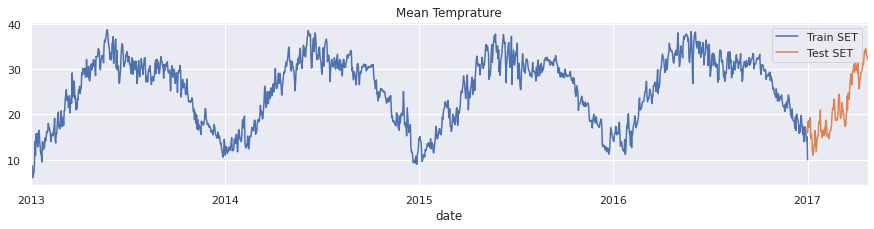

In [ ]:
MtempTrain = Train.drop([ 'humidity', 'wind_speed', 'meanpressure', 'year','month', 'day'], axis=1).set_index('date')
MtempTest = Test.drop([ 'humidity', 'wind_speed', 'meanpressure', 'year','month', 'day'], axis=1).set_index('date')

sns.set_theme()
_ = MtempTrain \
    .rename(columns={'meantemp': 'Train SET'}) \
    .join(MtempTest.rename(columns={'meantemp': 'Test SET'}), how='outer') \
    .plot(figsize=(15,3), title='Mean Temprature')

In [ ]:
X_train = Train.drop(['meantemp', 'date',  'year', 'day'], axis=1)
y_train = MtempTrain
X_test = Test.drop(['meantemp', 'date',  'year', 'day'], axis=1)
y_test = MtempTest

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[09:16:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

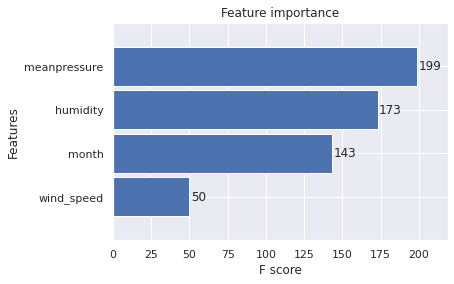

In [ ]:
_ = plot_importance(model, height=0.9)

In [ ]:
y_test['y_pred'] = model.predict(X_test)
total = pd.concat([y_test, y_train[::-1]], sort=False)
total.columns = ['Actual', 'y_pred']

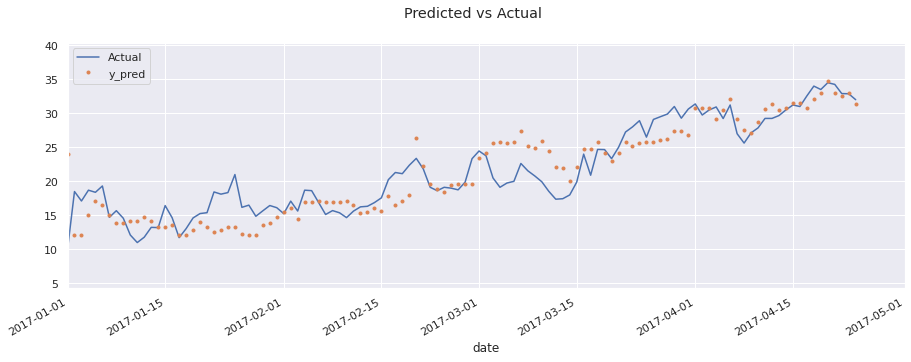

In [ ]:
sns.set_theme()
f, ax = plt.subplots(1)
_ = total[['Actual','y_pred']].plot(figsize=(15, 5), ax=ax, style=['-','.'])
ax.set_xbound(lower='2017-01-01', upper='2017-05-01')
plot = plt.suptitle('Predicted vs Actual')

In [ ]:
MAE = metrics.mean_absolute_error(y_test['meantemp'], y_test['y_pred'])
RMSE = np.sqrt(metrics.mean_squared_error(y_test['meantemp'], y_test['y_pred']))
MSE = metrics.mean_squared_error(y_test['meantemp'], y_test['y_pred'])
R2 = metrics.r2_score(y_test['meantemp'], y_test['y_pred'])

In [ ]:
print('MAE : ', MAE, '\n', 'RMSE : ', RMSE, '\n', 'R2 score : ', R2)

MAE :  2.2490863897532485 
 RMSE :  2.9256372906933095 
 R2 score :  0.7865268148357867
